# Train Convolutional `LSTM`


In this notebook, a simple next frame video prediction using convolutional `LSTM` is demonstrated.

## Imports

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet
!pip install ml_collections --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import serket as sk
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive widgets for visualization
import optax  # gradient based optimization
from typing import Any
from ml_collections import ConfigDict  # creating simple configuration files
from typing_extensions import Annotated  # adding type annotations to arrays
from tqdm import tqdm  # progress bar
config = ConfigDict()

## Create data

In [3]:
def create_circle_frames_numpy(
    frame_size: int,
    num_frames: int,
    radius_increment: int,
    x_shift = 0,
    y_shift =0 ,
) -> jax.Array:
    """Return frames of a circle growing in size.

    Args:
        frame_size: Size of the frame.
        num_frames: Number of frames to generate.
        radius_increment: Increment of radius between frames.
        shift: Shift of the circle's center.
    """
    center = frame_size // 2

    def draw_solid_circle_numpy(radius):
        frame = jnp.zeros((frame_size, frame_size))
        x, y = jnp.meshgrid(jnp.arange(frame_size), jnp.arange(frame_size))
        distances = (x - (center+x_shift)) ** 2 + (y - (center+y_shift)) ** 2
        frame = jnp.where(distances <= radius**2, 1, 0)
        return frame

    radii = jnp.arange(1, num_frames + 1) * radius_increment
    result = jax.vmap(draw_solid_circle_numpy)(radii)
    # add channel dimension
    return jnp.expand_dims(result, axis=1).astype(jnp.float32)

In [4]:
config.num_frames = 5
config.samples_count = 20
config.frame_size = 32

x_shifts = jr.randint(jr.PRNGKey(0), (config.samples_count,), -(config.frame_size //2), config.frame_size //2)
y_shifts = jr.randint(jr.PRNGKey(1), (config.samples_count,),-(config.frame_size //2), config.frame_size //2)
data = jax.vmap(lambda xs,ys : create_circle_frames_numpy(config.frame_size, config.num_frames, 1, xs, ys))(x_shifts, y_shifts)
train_data, test_data = data[:int(0.8*len(data))], data[int(0.8*len(data)):]
x_train, y_train = train_data[:, :-1], train_data[:, 1:]
x_test, y_test = test_data[:, :-1], test_data[:, 1:]

## Visualize data

Plot each sample for each row and the frames on columns

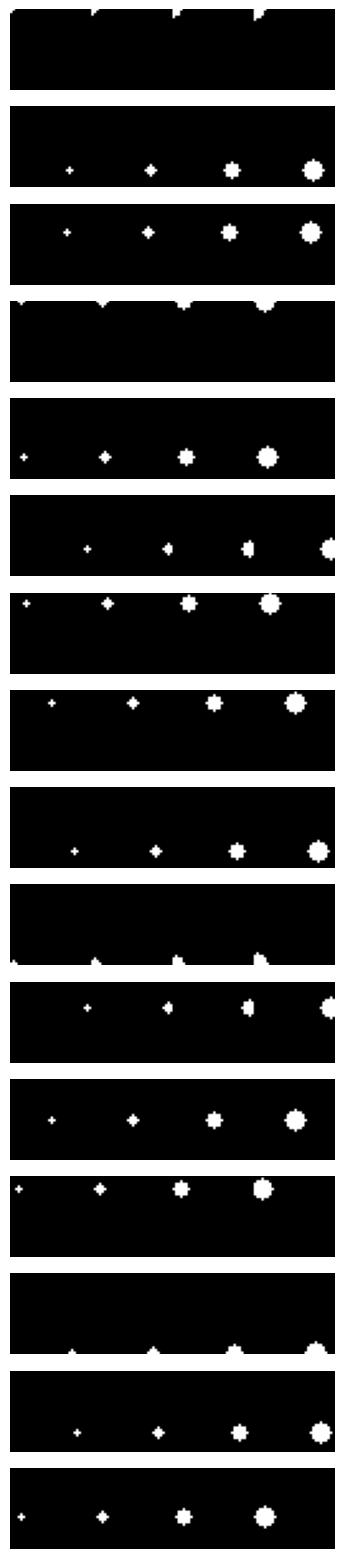

In [5]:
image = x_train[:,:,0]
image = image.transpose(0,2,1,3)
samples,frame_size,frame_count, _ = image.shape
image = image.reshape(samples,frame_size,frame_count*frame_size)
fig, axes = plt.subplots(len(image),1, figsize=(10,20))
for i,ax in enumerate(axes.ravel()):
    ax.axis('off')
    ax.imshow(image[i], cmap='gray')

## Model

In [6]:
class Net(sk.TreeClass):
    def __init__(self, hidden_features: int, *, key: jax.Array):
        k1, k2, k3, k4 = jr.split(key, 4)
        self.convlstm1 = sk.nn.ScanRNN(
            cell=sk.nn.ConvLSTM2DCell(
                in_features=1,
                hidden_features=hidden_features,
                kernel_size=5,
                padding="same",
                key=k1,
            ),
            return_sequences=True,
        )
        self.convlstm2 = sk.nn.ScanRNN(
            cell=sk.nn.ConvLSTM2DCell(
                in_features=hidden_features,
                hidden_features=hidden_features,
                kernel_size=3,
                padding="same",
                key=k2,
            ),
            return_sequences=True,
        )
        self.convlstm3 = sk.nn.ScanRNN(
            cell=sk.nn.ConvLSTM2DCell(
                in_features=hidden_features,
                hidden_features=hidden_features,
                kernel_size=1,
                padding="same",
                key=k3,
            ),
            return_sequences=True,
        )
        self.conv = sk.nn.Conv2D(
            in_features=hidden_features,
            out_features=1,
            kernel_size=3,
            padding="same",
            key=k4,
        )

    def __call__(
        self, input: Annotated[jax.Array, "f32[F,1,H,W]"]
    ) -> Annotated[jax.Array, "f32[F,1,H,W]"]:
        input = jax.nn.relu(self.convlstm1(input))
        input = jax.nn.relu(self.convlstm2(input))
        input = jax.nn.relu(self.convlstm3(input))
        input = jax.vmap(self.conv)(input)  # vectorize over frames
        return jax.nn.sigmoid(input)

## Training

In [7]:
config.hidden_features = 64
config.epochs = 1000
config.key = jr.PRNGKey(0)
config.optim = ConfigDict()
config.optim.kind = "adam"
config.optim.init_value = 1e-2
config.optim.boundaries = [
    int(config.epochs * 0.25),
    int(config.epochs * 0.5),
    int(config.epochs * 0.75),
]
config.optim.scales = [0.5, 0.5, 0.5]


def train(config: ConfigDict)->Net:
    lr = optax.piecewise_constant_schedule(
        init_value=config.optim.init_value,
        boundaries_and_scales=dict(zip(config.optim.boundaries, config.optim.scales)),
    )
    optim = getattr(optax, config.optim.kind)(learning_rate=lr)
    net = sk.tree_mask(Net(hidden_features=config.hidden_features, key=config.key))
    optim_state = optim.init(net)

    print(sk.tree_summary(net, depth=1))

    def loss_func(
        net: Net,
        xb: Annotated[jax.Array, "f32[N,F,1,H,W]"],
        yb: Annotated[jax.Array, "f32[N,F,1,H,W]"],
    ):
        net = sk.tree_unmask(net)
        logits = jax.vmap(net)(xb)  # vectorize over the batch dimension
        return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, yb))

    @jax.jit
    def train_step(
        net: Net,
        optim_state: Any,
        xb: Annotated[jax.Array, "f32[N,F,1,H,W]"],
        yb: Annotated[jax.Array, "f32[N,F,1,H,W]"],
    ):
        loss, grads = jax.value_and_grad(loss_func)(net, xb, yb)
        updates, optim_state = optim.update(grads, optim_state)
        net = optax.apply_updates(net, updates)
        return net, optim_state, loss

    for _ in (epoch_bar := tqdm(range(config.epochs))):
        net, optim_state, loss = train_step(net, optim_state, x_train, y_train)
        epoch_bar.set_description(f"Loss: {loss:.4e}")

    net = sk.tree_unmask(net)
    return net


net = train(config)

┌──────────┬───────────────────────┬───────┬────────┐
│Name      │Type                   │Count  │Size    │
├──────────┼───────────────────────┼───────┼────────┤
│.convlstm1│ScanRNN[ConvLSTM2DCell]│416,256│1.59MB  │
├──────────┼───────────────────────┼───────┼────────┤
│.convlstm2│ScanRNN[ConvLSTM2DCell]│295,168│1.13MB  │
├──────────┼───────────────────────┼───────┼────────┤
│.convlstm3│ScanRNN[ConvLSTM2DCell]│33,024 │129.00KB│
├──────────┼───────────────────────┼───────┼────────┤
│.conv     │Conv2D                 │577    │2.25KB  │
├──────────┼───────────────────────┼───────┼────────┤
│Σ         │Net                    │745,025│2.84MB  │
└──────────┴───────────────────────┴───────┴────────┘


Loss: 6.7986e-01: 100%|██████████| 1000/1000 [01:20<00:00, 12.39it/s]


## Visualize test predictions

(4, 32, 4, 32)


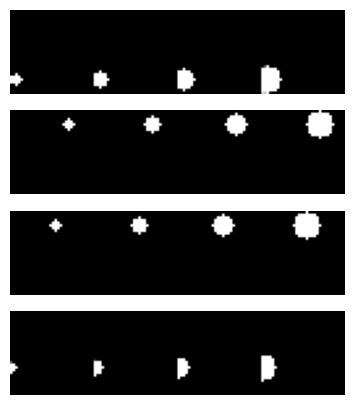

In [8]:
y_test_pred = jax.vmap(net)(x_test)
image_pred = y_test_pred[:,:,0]
image_pred = image_pred.transpose(0,2,1,3)
print(image_pred.shape)
samples,frame_size,frame_count, _ = image_pred.shape
image_pred = image_pred.reshape(samples,frame_size,frame_count*frame_size)

fig, axes = plt.subplots(len(image_pred),1, figsize=(10,5))

for i,ax in enumerate(axes.ravel()):
    ax.axis('off')
    ax.imshow(image_pred[i], cmap='gray')

Inspired by https://keras.io/examples/vision/conv_lstm/